### 2.1 データセット

2.1.1 初めてのHugging Face Datasets

In [1]:
# from datasets import list_datasets

# all_datasets = list_datasets()
# print(f"There are {len(all_datasets)} datasets currently available on the Hub")
# print(f"The first 10 are: {all_datasets[:10]}")


In [2]:
from datasets import load_dataset

In [3]:
#emotions = load_dataset("dair-ai/emotion")
#emotions = load_dataset("dair-ai/emotion", "unsplit")
emotions = load_dataset("dair-ai/emotion")
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
len(train_ds)

16000

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_ds.column_names

['text', 'label']

+ DatasetオブジェクトはApacheArrowをベースにしたネイティブPythonよりメモリ効率の良い型付きの列指向形式
+ Datasetオブジェクトのfeatures属性にアクセスして内部構造がわかる

In [8]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [9]:
# スライスを用いて複数行にアクセス
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [10]:
# 列名指定
print(train_ds['text'][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


データセットを分割してダウンロードできる

In [11]:
#dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
#!wget { dataset_url }

In [12]:
#!head -n 1 train.txt

In [13]:
#!Get-Content train.txt | Select-Object -First 10

In [14]:
#emotions_local = load_dataset("csv", data_files="train.txt", sep=";", names=["text", "label"])

In [15]:
#emotions_local

In [11]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


データセットのクラス分布

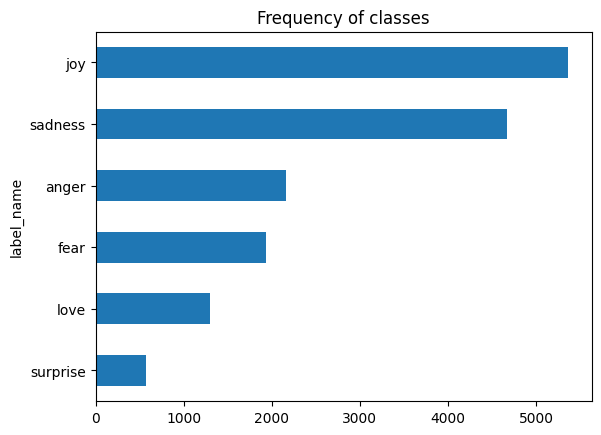

In [13]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

データセットのツイートの長さを調べる
+ Transformerモデルのトークン長の制限を許容できるか判断するため
+ DistilBERTの最大トークン長は512

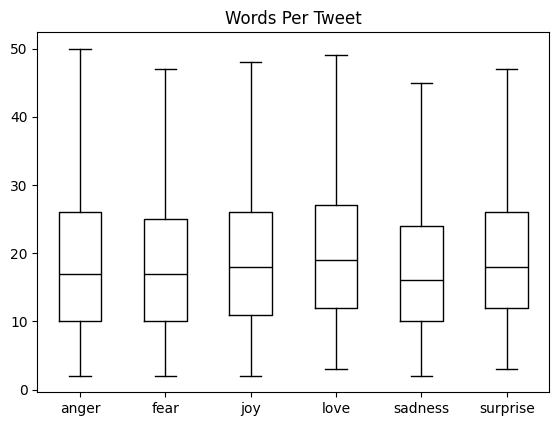

In [14]:
# ツイート毎の単語数の分布を見る
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show() # どのラベルもツイートは15単語程度なのでOK

In [15]:
# データセットの出力形式をリセット
emotions.reset_format()

### 2.2 テキストからトークンへ
+ 文字トークン化(シンプル)
+ 単語トークン化
+ サブワードトークン化

#### 2.2.1 文字トークン化

In [17]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [22]:
# 一意なトークンを一意な整数にエンコード
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [23]:
# トークンマップを用いてテキストのトークン列を整数に変換
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


+ 2つのID(数値)を足し引きして結果のIDが全く意味合いが異なるIDになってはいけない

In [24]:
categorical_df = pd.DataFrame({"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0, 1, 2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [25]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


In [34]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings

NameError: name 'input_ids' is not defined

In [27]:
one_hot_encodings.shape

torch.Size([38, 20])

In [28]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


#### 2.2.2 単語トークン化

In [18]:
print(text)
tokenized_text = text.split()
print(tokenized_text)

Tokenizing text is a core task of NLP.
['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


+ 単語トークン化の弱点は, 100万語を1000次元に圧縮する行列Wを用いたとして、これだけで10億パラメータが必要になる。
+ 稀な単語は捨てたり、<UNK>トークンにしたりするが、情報が欠落してしまう欠点がある。

#### サブワードトークン化
+ 統計的ルールとアルゴリズムを組み合わせて、事前学習用のコーパスかえらトークン化を学習すること

BERTとDistilBERTで利用されている**WordPiece**トークナイザー

In [19]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [31]:
# from transformers import DistilBertTokenizer
# distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [20]:
print(text)
encoded_text = tokenizer(text)
print(encoded_text)

Tokenizing text is a core task of NLP.
{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [21]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [22]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [23]:
# AutoTokenizerクラスはトークナイザーに関する情報を持つ
tokenizer.vocab_size # 語彙数

30522

In [24]:
tokenizer.model_max_length # モデルの最大コンテキストサイズ

512

In [25]:
# モデルが期待する入力変数の名前
tokenizer.model_input_names

['input_ids', 'attention_mask']

2.2.4 データセット全体のトークン化

In [26]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [27]:
print(tokenize(emotions['train'][0]))
print(tokenize(emotions['train'][1]))


{'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [28]:
# 複数のデータセットを入力しないとpaddingしない
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [29]:
specified_tokens_df = pd.DataFrame({
    'Special Token': ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]'],
    'Special Token Id': [0, 100, 101, 102, 103]
}).transpose()
specified_tokens_df

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token Id,0,100,101,102,103


In [30]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [31]:
# データセット'train', 'validation', 'test'に対してtokenizeを処理する
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [32]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [45]:
emotions_encoded['train'][0]

{'text': 'i didnt feel humiliated',
 'label': 0,
 'input_ids': [101,
  1045,
  2134,
  2102,
  2514,
  26608,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

#### 2.3.1 特徴抽出器としてのTransformer

In [35]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device) # AutoModelクラスはトークンエンコーディングを埋め込みに変換し、エンコーダスタックを経由して隠れ状態を返す。

C:\Users\InoueShinichi\.conda\envs\Book_Transformers\Lib\site-packages\transformers\modeling_utils.py:1435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

2.3.1.2 最後の隠れ状態の抽出

In [36]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}") # [batch_size, n_tokens]

Input tensor shape: torch.Size([1, 6])


In [37]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [38]:
outputs.last_hidden_state.size() # [batch_size, token_size, dim]

torch.Size([1, 6, 768])

In [39]:
# [CLS]トークンに相当する隠れ状態だけ取り出す
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

最後の隠れ層の[CLS]トークンに相当する隠れベクトルをデータセット全体に対して適用して、一つの行列として取り出す関数


In [40]:
def extract_hidden_states(batch):
    # モデルの入力をGPU上へ転送
    _inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    # 最後の隠れ状態を抽出
    with torch.no_grad():
        last_hideen_states = model(**_inputs).last_hidden_state
    # [CLS]トークンに対応するベクトルを返す
    return {"hidden_state": last_hideen_states[:,0].cpu().numpy()}

In [41]:
# input_idsとattention_maskの列をtorch形式に変換
print(emotions_encoded) # DatasetオブジェクトはApacheArrowをベースにしたネイティブPythonよりメモリ効率の良い型付きの列指向形式
emotions_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [42]:
# 一括して各データセットを入力したTransformerモデルの最終隠れ層の[CLS]に対応するベクトルを取り出す
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True) # batched=Trueでデフォルトのバッチサイズが適用される。この場合1000

In [43]:
emotions_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [44]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

2.3.1.3 特徴行列の作成

In [45]:
import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
X_train.shape, X_valid.shape

C:\Users\InoueShinichi\AppData\Local\Temp\ipykernel_9040\469332173.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_train = np.array(emotions_hidden['train']['hidden_state'])
C:\Users\InoueShinichi\AppData\Local\Temp\ipykernel_9040\469332173.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_valid = np.array(emotions_hidden['validation']['hidden_state'])
C:\Users\InoueShinichi\AppData\Local\Temp\ipykernel_9040\469332173.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_train = np.array(emotions_hidden['train']['label'])
C:\Users\InoueShinichi\AppData\Local\Temp\ipykernel_9040\469332173.py:6: DeprecationWar

((16000, 768), (2000, 768))

2.3.1.4 学習データセットの可視化
+ 768次元ベクトルを2次元ベクトルに次元削減するためにUMAPアルゴリズムを適用

In [46]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 特徴を[0,1]区間にスケールする
X_scaled = MinMaxScaler().fit_transform(X_train)

# UMAPの初期化とfit
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

# 2次元埋め込みのDataFrameを作成
df_emb = pd.DataFrame(mapper.embedding_, columns=['X','Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,4.258216,2.946475,0
1,-3.337619,3.565574,0
2,4.969702,6.502039,3
3,-2.527961,5.438173,2
4,-3.599783,5.416068,3


次元削減した特徴量をもう少しカテゴリごとに調査

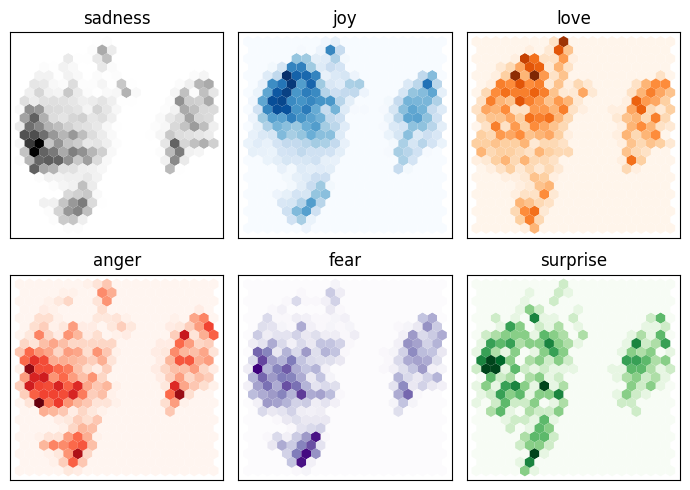

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f'label == {i}')
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

2.3.1.5 単純な分類器の学習
+ scikit-learnのlogistic分類器を使う

In [48]:
from sklearn.linear_model import LogisticRegression

# 収束を保証するために'max_iter'の値を増加
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
Accuracy = lr_clf.score(X_valid, y_valid) # 検証データによる正解率
print(f"Accuracy: {Accuracy}")

Accuracy: 0.634


In [49]:
# 適当な分類器と比較
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent') # 多数派戦略
dummy_clf.fit(X_train, y_train)
acc = dummy_clf.score(X_valid, y_valid) # 正解率
print(f"Accuracy: {acc}")

Accuracy: 0.352


混同行列で分類状態をチェック


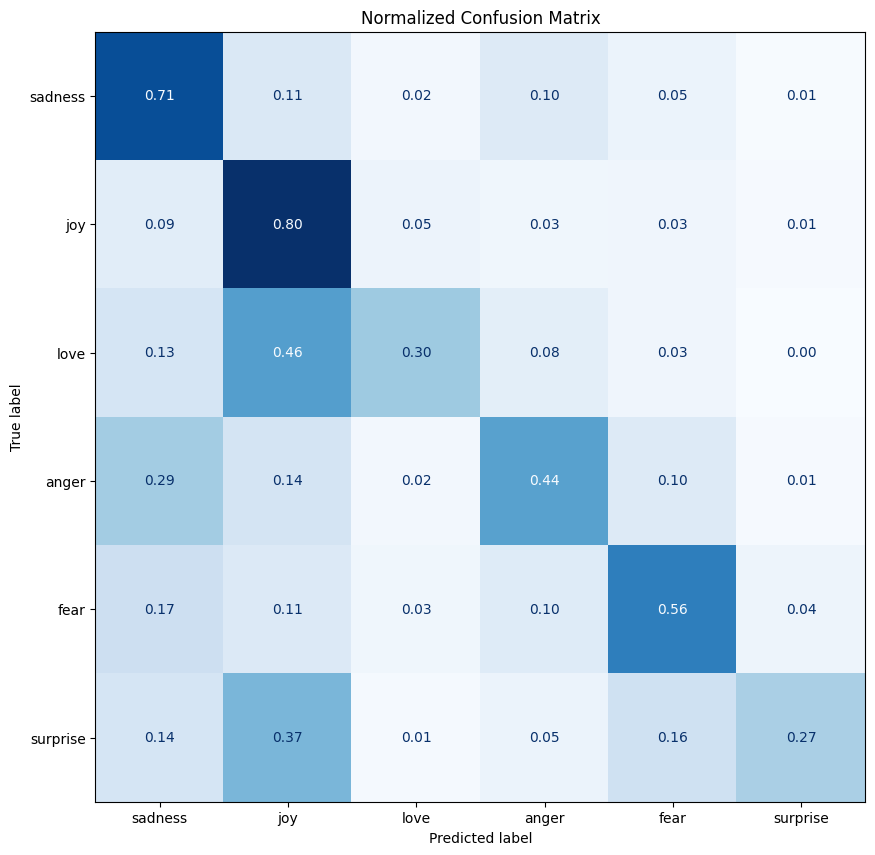

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()


y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### 2.3.2 Transformerのファインチューニング

+ Trainer API
+ AutoModelForSequenceClassificationモデルが事前学習済みモデルの出力の上に分類ヘッドを持っている

In [52]:
# 分類数は自分で決める
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

C:\Users\InoueShinichi\.conda\envs\Book_Transformers\Lib\site-packages\transformers\modeling_utils.py:1435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

2.3.2.2 性能指標の定義

In [53]:
# F1スコア
from sklearn.metrics import accuracy_score, f1_score

# EvalPredictionオブジェクト(predictionsとlabel_ids属性の名前付きタプル)を
# 引数にとり、各指標の名前とその値を対応させた辞書を返す必要がある関数
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"f1": f1, "acc": acc}

##### HuggingFaceにログイン

In [104]:
from huggingface_hub import notebook_login

notebook_login()

In [105]:
# 学習用ハイパーパラメータ用クラス
from transformers import Trainer, TrainingArguments, IntervalStrategy

batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f"TinyTank/{model_ckpt}-finetuned-emotion"
print(model_name)
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy=IntervalStrategy.EPOCH,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error",
)

TinyTank/distilbert-base-uncased-finetuned-emotion


In [106]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer,
                  )

# torch.cuda.set_device('cuda:1')
print(f"device: {torch.cuda.current_device()}")
trainer.train()

device: 0


C:\Users\InoueShinichi\.conda\envs\Book_Transformers\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\InoueShinichi\.conda\envs\Book_Transformers\Lib\site-packages\torch\nn\parallel\data_parallel.py:37: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(
C:\Users\InoueShinichi\.conda\envs\Book_Transformers\Lib\site-packages\torch\nn\parallel\_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings

Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,0.384089,0.935839,0.936000
2,0.008100,0.363888,0.933118,0.933000


C:\Users\InoueShinichi\.conda\envs\Book_Transformers\Lib\site-packages\torch\nn\parallel\_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
C:\Users\InoueShinichi\.conda\envs\Book_Transformers\Lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")
C:\Users\InoueShinichi\.conda\envs\Book_Transformers\Lib\site-packages\torch\nn\parallel\data_parallel.py:37: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(


TrainOutput(global_step=250, training_loss=0.008105481147766113, metrics={'train_runtime': 88.6103, 'train_samples_per_second': 361.132, 'train_steps_per_second': 2.821, 'total_flos': 720342861696000.0, 'train_loss': 0.008105481147766113, 'epoch': 2.0})

In [107]:
# 混同行列を出力

preds_output = trainer.predict(emotions_encoded['validation'])
preds_output.metrics

C:\Users\InoueShinichi\.conda\envs\Book_Transformers\Lib\site-packages\torch\nn\parallel\data_parallel.py:37: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(
C:\Users\InoueShinichi\.conda\envs\Book_Transformers\Lib\site-packages\torch\nn\parallel\_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'test_loss': 0.3638882637023926,
 'test_f1': 0.9331183988173117,
 'test_acc': 0.933,
 'test_runtime': 2.6673,
 'test_samples_per_second': 749.809,
 'test_steps_per_second': 5.998}

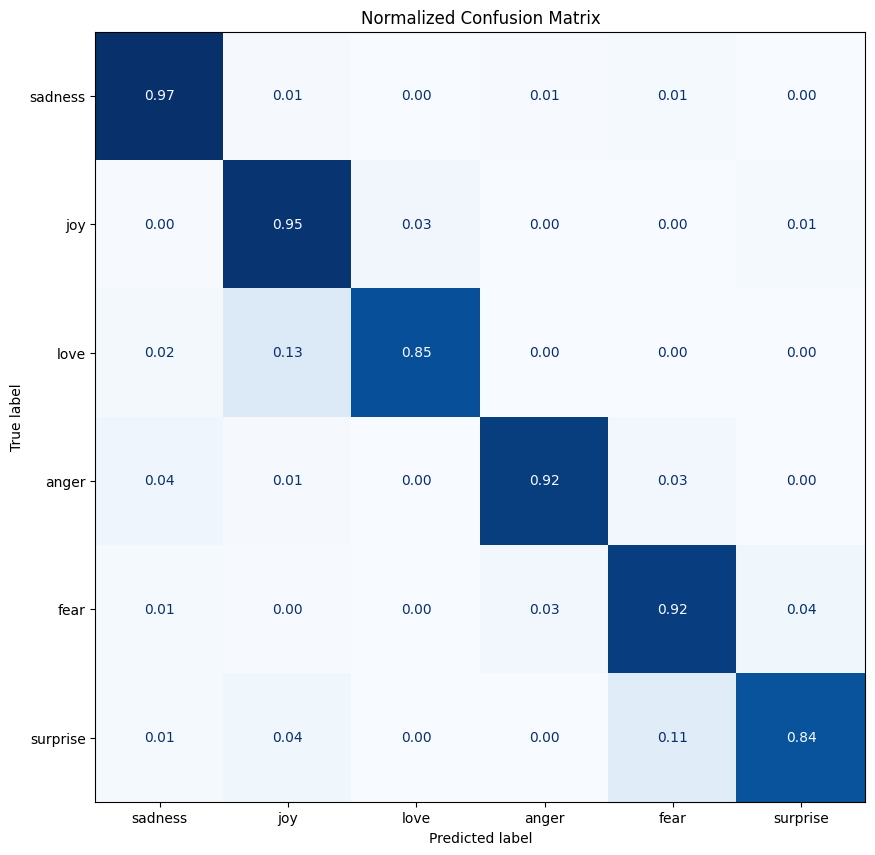

In [108]:
# 各クラスの生の予測値を取り出す
y_preds = np.argmax(preds_output.predictions, axis=1)

# プロット
plot_confusion_matrix(y_preds, y_valid, labels)

2.3.2.4 エラー分析

In [109]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, dim=-1)
        loss = cross_entropy(output.logits, batch['label'].to(device), reduction="none")

        # データセットの他の列との互換性を保つため、出力をCPU上に配置する
        return {
            "loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()
        }


In [110]:
# DictDataset -> torch.tensor
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# 損失の計算
emotions_encoded['validation'] = emotions_encoded['validation'].map(forward_pass_with_label, batched=True, batch_size=16)



Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [111]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded['validation'][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

# 損失が高い10件
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,13.736853
1801,i feel that he was being overshadowed by the s...,love,sadness,13.679817
1509,i guess this is a memoir so it feels like that...,joy,fear,11.802736
1919,i should admit when consuming alcohol myself i...,fear,sadness,11.621533
415,im kind of embarrassed about feeling that way ...,love,sadness,11.593937
1322,i hate being the party girl because i feel lik...,sadness,anger,10.671423
292,i can say is that i feel like myself when i pu...,love,joy,10.615710
1124,someone acting stupid in public,anger,sadness,10.594071
300,i have had several new members tell me how com...,love,joy,10.290679
1943,i think that in this way though the readers wi...,love,joy,9.924733


In [112]:
# 損失が少ない10件
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.000006
473,i have this mixed up kinda feeling and i reall...,sadness,sadness,0.000006
264,i am left feeling underwhelmed and ungrateful,sadness,sadness,0.000006
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.000006
1886,i feel unloved and know im hated,sadness,sadness,0.000006
1303,i feel pathetic and uninspired,sadness,sadness,0.000006
625,i feel unwelcome in this town as if my time he...,sadness,sadness,0.000006
1665,i feel a lil bit gloomy,sadness,sadness,0.000006
1531,i forgive stanley hes not so quick to forgive ...,sadness,sadness,0.000006
369,i just need a few minutes to feel put upon and...,sadness,sadness,0.000006


2.3.2.5 モデルの保存と共有

In [90]:
from huggingface_hub import notebook_login

notebook_login()

In [114]:
from huggingface_hub import HfApi

api = HfApi(token="")
api.upload_folder(
    folder_path=R"C:\Users\InoueShinichi\OneDrive\Desktop\MyGithub\Book_Transformers\TinyTank\distilbert-base-uncased-finetuned-emotion",
    repo_id="TinyTank/distilbert-base-uncased-finetuned-emotion",
    repo_type="model",
)

events.out.tfevents.1750200814.DESKTOP-A6ASJMV.9040.10:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

events.out.tfevents.1750200824.DESKTOP-A6ASJMV.9040.13:   0%|          | 0.00/4.91k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

events.out.tfevents.1750200814.DESKTOP-A6ASJMV.9040.11:   0%|          | 0.00/4.91k [00:00<?, ?B/s]

Upload 8 LFS files:   0%|          | 0/8 [00:00<?, ?it/s]

events.out.tfevents.1750200824.DESKTOP-A6ASJMV.9040.12:   0%|          | 0.00/4.93k [00:00<?, ?B/s]

events.out.tfevents.1750201334.DESKTOP-A6ASJMV.9040.14:   0%|          | 0.00/4.93k [00:00<?, ?B/s]

events.out.tfevents.1750201334.DESKTOP-A6ASJMV.9040.15:   0%|          | 0.00/4.91k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/TinyTank/distilbert-base-uncased-finetuned-emotion/commit/69b41f6c3bdea711adca7c9d979951d9f3ff8da0', commit_message='Upload folder using huggingface_hub', commit_description='', oid='69b41f6c3bdea711adca7c9d979951d9f3ff8da0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/TinyTank/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='TinyTank/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

In [113]:
trainer.push_to_hub(commit_message="This is a test")



AttributeError: 'Trainer' object has no attribute 'repo'

In [123]:
from transformers import pipeline

model_id = "TinyTank/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline('text-classification', model=model_id, tokenizer=tokenizer)

custom_tweet = "My paddy field is grown suddenly."
preds = classifier(custom_tweet, return_all_scores=True)
preds

C:\Users\InoueShinichi\.conda\envs\Book_Transformers\Lib\site-packages\transformers\modeling_utils.py:1435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

[[{'label': 'LABEL_0', 'score': 0.0029563482385128736},
  {'label': 'LABEL_1', 'score': 0.7457382082939148},
  {'label': 'LABEL_2', 'score': 0.00035574191133491695},
  {'label': 'LABEL_3', 'score': 0.01212734542787075},
  {'label': 'LABEL_4', 'score': 0.23717962205410004},
  {'label': 'LABEL_5', 'score': 0.0016426451038569212}]]

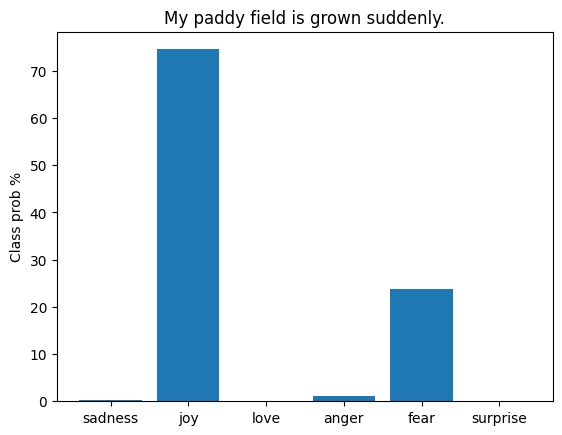

In [124]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df['score'], color='C0')
plt.title(f"{custom_tweet}")
plt.ylabel("Class prob %")
plt.show()